# CME 241 (Winter 2021) -- Assignment 11

In [1]:
from typing import (
    Iterable, 
    TypeVar, 
    Mapping, 
    List, 
    Tuple, 
    Sequence,
    Callable
)
import itertools as it
from collections import defaultdict
from pprint import pprint

import numpy as np

from rl.markov_process import TransitionStep, ReturnStep
from rl.returns import returns
from rl.chapter2.simple_inventory_mrp import (
    SimpleInventoryMRPFinite, 
    InventoryState
)
from rl.distribution import Choose
from rl.function_approx import (
    LinearFunctionApprox, 
    AdamGradient, 
    FunctionApprox
)
from rl.monte_carlo import mc_prediction
from rl.td import td_prediction
from rl.chapter10.prediction_utils import (
    mc_prediction_learning_rate,
    td_prediction_learning_rate,
)

## Question 1

In [2]:
S = TypeVar("S")
    
def tabular_mc_prediction(
    traces: Iterable[Iterable[TransitionStep[S]]],
    gamma: int = 1
) -> Mapping[S, float]:
    """Compute value function for finite number of states."""
    episodes = (returns(trace, gamma, 1e-5) for trace in traces)
    vf: Mapping[S, float] = defaultdict(float)
    counts: Mapping[S, int] = defaultdict(lambda: int(1))
    for n, episode in enumerate(episodes):
        for rs in episode:
            vf[rs.state] += (rs.return_ - vf[rs.state]) / counts[rs.state]
            counts[rs.state] += 1
    return vf

## Question 2

In [3]:
def tabular_td_prediction(
    traces: Iterable[TransitionStep[S]],
    gamma: int = 1
) -> Mapping[S, float]:
    """Compute value function for finite number of states."""
    V: Mapping[S, float] = defaultdict(float)
    for n, t in enumerate(traces, start=1):
        V[t.state] += 20 * (t.reward + gamma * V[t.next_state] - V[t.state]) / n
    return V

## Question 3

In [4]:
capacity: int = 2
poisson_lambda: float = 1.0
holding_cost: float = 1.0
stockout_cost: float = 10.0

gamma: float = 0.9

si_mrp: SimpleInventoryMRPFinite = SimpleInventoryMRPFinite(
    capacity=capacity,
    poisson_lambda=poisson_lambda,
    holding_cost=holding_cost,
    stockout_cost=stockout_cost,
)
nt_states: Sequence[InventoryState] = si_mrp.non_terminal_states
true_vf: np.ndarray = si_mrp.get_value_function_vec(gamma=gamma)

mc_episode_length_tol: float = 1e-6
num_episodes = 10000

td_episode_length: int = 100
initial_learning_rate: float = 0.03
half_life: float = 1000.0
exponent: float = 0.5

ffs: Sequence[Callable[[InventoryState], float]] = [
    (lambda x, s=s: float(x == s)) for s in nt_states
]

mc_ag: AdamGradient = AdamGradient(learning_rate=0.05, decay1=0.9, decay2=0.999)

td_ag: AdamGradient = AdamGradient(learning_rate=0.003, decay1=0.9, decay2=0.999)

mc_func_approx: LinearFunctionApprox[InventoryState] = LinearFunctionApprox.create(
    feature_functions=ffs, adam_gradient=mc_ag
)

td_func_approx: LinearFunctionApprox[InventoryState] = LinearFunctionApprox.create(
    feature_functions=ffs, adam_gradient=td_ag
)

it_mc: Iterable[FunctionApprox[InventoryState]] = mc_prediction_learning_rate(
    mrp=si_mrp,
    start_state_distribution=Choose(set(nt_states)),
    gamma=gamma,
    tolerance=mc_episode_length_tol,
    initial_func_approx=mc_func_approx,
)

it_td: Iterable[FunctionApprox[InventoryState]] = td_prediction_learning_rate(
    mrp=si_mrp,
    start_state_distribution=Choose(set(nt_states)),
    gamma=gamma,
    episode_length=td_episode_length,
    initial_func_approx=td_func_approx,
)

In [6]:
print("True Value Function")
print("--------------")
si_mrp.display_value_function(gamma=gamma)
print()

numsims = 2_000
distrib = Choose({s for s in si_mrp.states()})
traces = it.islice(si_mrp.reward_traces(distrib), numsims)

iters = it.tee(traces, 3)

print("Tabular MC Value Function")
print("-------------------------")
pprint(tabular_mc_prediction(iters[0], gamma))
print()

ffs: Sequence[Callable[[InventoryState], float]] = [
    (lambda x, s=s: float(x == s)) for s in nt_states
]

mc_func_approx: LinearFunctionApprox[InventoryState] = LinearFunctionApprox.create(
    feature_functions=ffs, adam_gradient=mc_ag
)
mc_candidates = list(mc_prediction(iters[1], mc_func_approx, gamma))
mc_sol = mc_candidates[-1]
print("Approx. MC Value Function")
print("-------------------------")
pprint({s: mc_sol.evaluate([s]) for s in si_mrp.states()})
print()

flattened = it.chain.from_iterable(it.islice(x, 500) for x in iters[2])
flats = it.tee(flattened)

td_vf = tabular_td_prediction(flats[0], gamma)
print("Tabular TD Value Function")
print("-------------------------")
pprint(td_vf)
print()

td_func_approx: LinearFunctionApprox[InventoryState] = LinearFunctionApprox.create(
    feature_functions=ffs, adam_gradient=td_ag
)
td_candidates = list(td_prediction(flats[1], td_func_approx, gamma))
td_sol = td_candidates[-1]
print("Approx. TD Value Function")
print("-------------------------")
pprint({s: td_sol.evaluate([s]) for s in si_mrp.states()})

True Value Function
--------------
{InventoryState(on_hand=1, on_order=0): -28.932,
 InventoryState(on_hand=0, on_order=0): -35.511,
 InventoryState(on_hand=2, on_order=0): -30.345,
 InventoryState(on_hand=0, on_order=1): -27.932,
 InventoryState(on_hand=0, on_order=2): -28.345,
 InventoryState(on_hand=1, on_order=1): -29.345}

Tabular MC Value Function
-------------------------
defaultdict(<class 'float'>,
            {InventoryState(on_hand=1, on_order=1): -29.300465812725957,
             InventoryState(on_hand=0, on_order=2): -28.32482386964092,
             InventoryState(on_hand=2, on_order=0): -30.410234539502156,
             InventoryState(on_hand=0, on_order=1): -27.897580095316076,
             InventoryState(on_hand=0, on_order=0): -35.487568872036555,
             InventoryState(on_hand=1, on_order=0): -28.874616456332365})

Approx. MC Value Function
-------------------------
{InventoryState(on_hand=1, on_order=0): array([-28.91137544]),
 InventoryState(on_hand=0, on_order

## Question 4

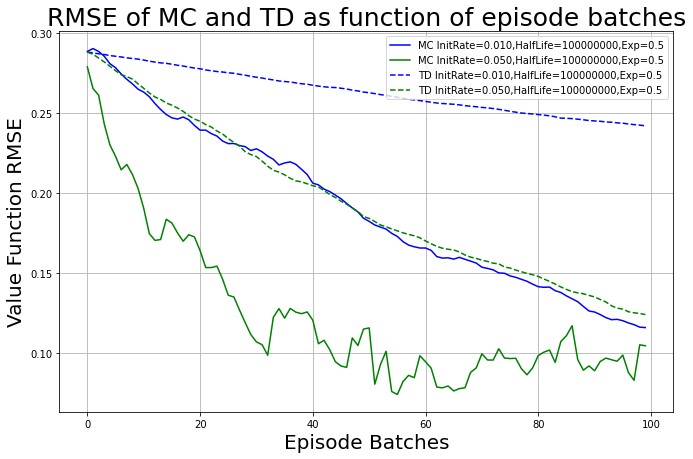

In [1]:
from walk import RandomWalk2D

from rl.chapter10.prediction_utils import compare_td_and_mc

B1, B2 = 10, 10
lprob, rprob, dprob, uprob = 0.25, 0.25, 0.25, 0.25
random_walk: RandomWalk2D = RandomWalk2D(B1, B2, lprob, rprob, dprob, uprob)
compare_td_and_mc(
    fmrp=random_walk,
    gamma=1.0,
    mc_episode_length_tol=1e-6,
    num_episodes=700,
    learning_rates=[(0.01, 1e8, 0.5), (0.05, 1e8, 0.5)],
    initial_vf_dict={s: 0.5 for s in random_walk.non_terminal_states},
    plot_batch=7,
    plot_start=0,
)